In [1]:
%%capture
!pip install yfinance

In [2]:
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, MonthLocator, YearLocator, DateFormatter

import pymc_experimental.statespace as pmss
import pymc as pm
import pandas as pd
import arviz as az
import yfinance as yf
import numpy as np
import os

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "figure.facecolor": "w",
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.spines.right": False,
    }
)

In [3]:
def plot_candlesticks(df, lw=0.5):
    delta = pd.Timedelta(hours=18)
    half_delta = pd.Timedelta(hours=9)

    gs = plt.GridSpec(nrows=4, ncols=1)
    fig = plt.figure()
    candlestick_ax = fig.add_subplot(gs[:-1, :])
    volume_ax = fig.add_subplot(gs[-1, :])

    # Draw the body
    candlestick_ax.hlines(df.Open, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.hlines(df.Close, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.vlines(df.index, df.Open, df.Close, lw=lw, color="k")
    candlestick_ax.vlines(df.index - delta, df.Open, df.Close, lw=lw, color="k")

    # Color

    color = (df.Close - df.Open).map(lambda x: "tab:red" if x < 0 else "tab:green")
    for c in ["tab:red", "tab:green"]:
        color_mask = color == c
        augmented_dates = np.column_stack(
            (
                df.index.values[color_mask],
                df.index.values[color_mask] - delta,
                np.full(color_mask.sum(), np.nan, dtype=np.datetime64),
            )
        )
        candlestick_ax.fill_between(
            augmented_dates.ravel(),
            df.Open.values[color_mask].repeat(3),
            df.Close.values[color_mask].repeat(3),
            color=c,
            alpha=0.5,
        )

    # Draw the wick
    max_open_close = df[["Open", "Close"]].max(axis=1)
    min_open_close = df[["Open", "Close"]].min(axis=1)

    candlestick_ax.hlines(df.High, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.hlines(df.Low, df.index - delta, df.index, lw=lw, color="k")
    candlestick_ax.vlines(df.index - half_delta, max_open_close, df.High, lw=lw, color="k")
    candlestick_ax.vlines(df.index - half_delta, min_open_close, df.Low, lw=lw, color="k")
    candlestick_ax.set(xticklabels=[], ylabel="Price")

    volume_ax.bar(df.index, df.Volume, color=color, alpha=0.5)
    volume_ax.bar(df.index, df.Volume, edgecolor="k", facecolor="none", lw=1)

    volume_ax.xaxis.set_major_locator(MonthLocator(interval=1))
    volume_ax.xaxis.set_minor_locator(DayLocator(interval=7))
    volume_ax.xaxis.set_major_formatter(DateFormatter("%b"))

    years = YearLocator()
    years_fmt = DateFormatter("%Y")
    xmin, xmax = volume_ax.get_xlim()

    for year in years.tick_values(df.index.min(), df.index.max()):
        volume_ax.text(
            max(year, xmin),
            -0.6,
            years_fmt(year),
            transform=volume_ax.get_xaxis_transform(),
            ha="center",
            fontsize=9,
        )

    volume_ax.set(ylabel="Volume")

    return fig

# Exponential Trend Smoothing

Exponential Trend Smoothing (ETS) models are a powerful family of timeseries models purpose build for forecasting. Early researchers working, including [Brown (1959)](#Brown1959), [Holt (1957)](#Holt1957), and [Winters (1960)](#Winters1960) on these models were concered first and foremost with forcasting. [Forcasting, Principals and Practice, Chapter 8](https://otexts.com/fpp3/expsmooth.html) should be regarded as the first and last word on these methods. This presentation will draw heavily on this chapter, and it should be consulted for a deeper understanding of the ETS method.

ETS begins from a simple proposition: the future should look like the past. This is a common enough proposition in time series modeling -- all models end up using past observations as "features" in the models. The question is "which past should be used?".

To think through this question, we'll use some stock price data. Stock prices are notoriously hard to forecast, so it will be a nice testbed. Let's look at the hottest tech stock at the time of writing, Nvidia ($NVDA), manufacturer of GPUs used to train large language models (and, more importantly, to do ray-tracing in Minecraft mods).


In [4]:
if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.exists("data/nvda-1yr.csv"):
    today = pd.to_datetime("2024-08-10")
    year_delta = pd.Timedelta(days=365)

    nvda = yf.Ticker("NVDA").history(start=today - year_delta, end=today)
    nvda.to_csv("data/nvda-1yr.csv")
else:
    nvda = pd.read_csv("data/nvda-1yr.csv")
    nvda.Date = pd.to_datetime(nvda.Date, utc=True).dt.tz_localize(None)
    nvda = nvda.set_index("Date")

In [5]:
train_pct = 0.7
test_pct = 0.2
dev_pct = 0.1

assert np.allclose(train_pct + test_pct + dev_pct, 1.0)
T = nvda.shape[0]
range_idx = np.arange(T)
cutpoints = np.quantile(range_idx, np.cumsum([train_pct, test_pct, dev_pct])).astype(int)

train_end_date = nvda.index[cutpoints[0]]
test_end_date = nvda.index[cutpoints[1]]

df_train = nvda.loc[:train_end_date]
df_test = nvda.loc[train_end_date:test_end_date]
df_dev = nvda.loc[test_end_date:]


# Resample to business days, just so we can have a frequency on the index
# This will introduce missing values on days when the market is closed, but that's ok
df_train = df_train.resample("B").first()
df_train.index.freq = df_train.index.inferred_freq

Nvidia has been enjoying a crazy bull run for the last couple years. At the time of writing (Aug 10, 2024), though, there's been a huge pullback in technology stocks over the past few weeks. This notebook will hopefully end up as something of a cautionary tale about predicting stock prices: don't try!

Here is the candlestick plot for NVDA between August 2023 and June 2024. These are a favorite of so-called "technical analysts", who use them to look for patterns, which they then use to trade on and lose money (in expectation). Can you spot the head and shoulders formation? Me either. They are quite pretty though, and summarize a lot of information in an easy-to-read way.

Each "candlestick" is a day of trading activity. The size of the candlestick (the colored rectangle) is the size of the day's opening price minus the closing price. If it's red, the stock closed lower than it opened (went down over the day). Green means it went up over the day.

The "wick" show the day's high and low price -- the maximum price that was attained that day. 

At the bottom is the daily training volume: the number of transations between buyers and sellers that took place voer the course of the day. For a big popular stock like Nvidia, this is a big number: notice that the y-axis scale is in billions!

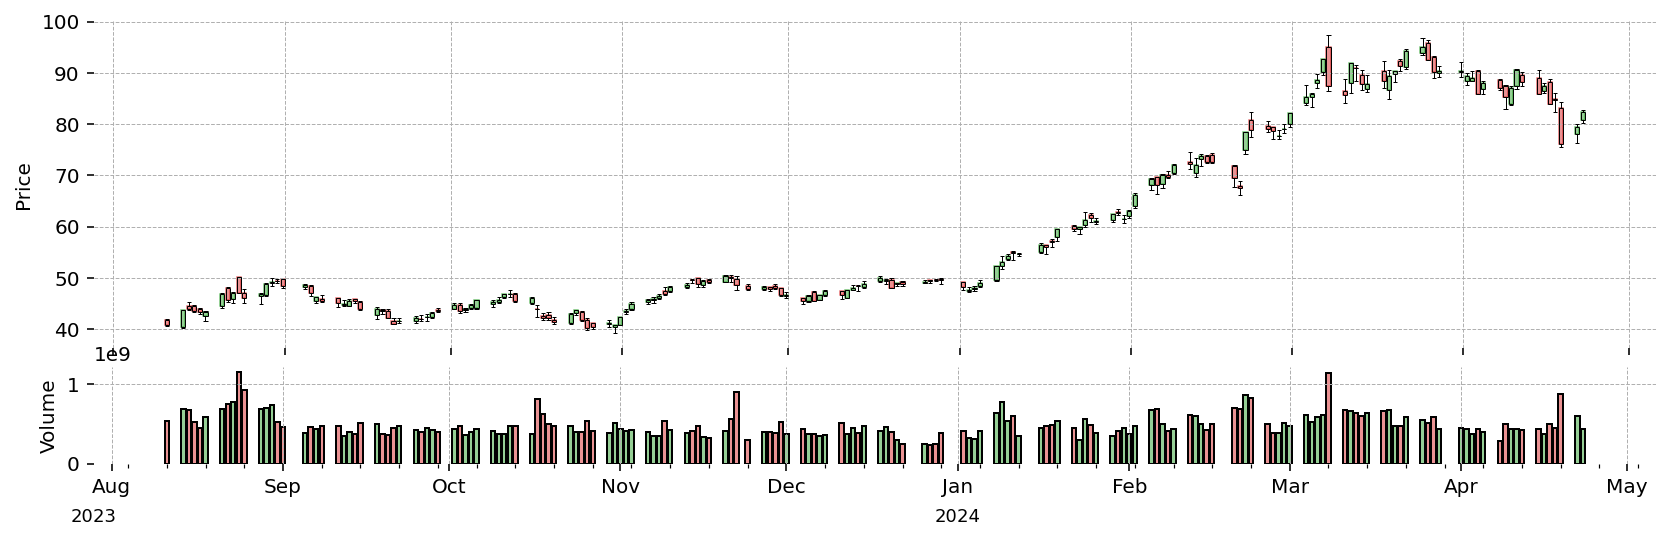

In [11]:
plot_candlesticks(df_train);

Zooming in on just January 2024 to March 2024 makes the candlesticks a bit easier to see:

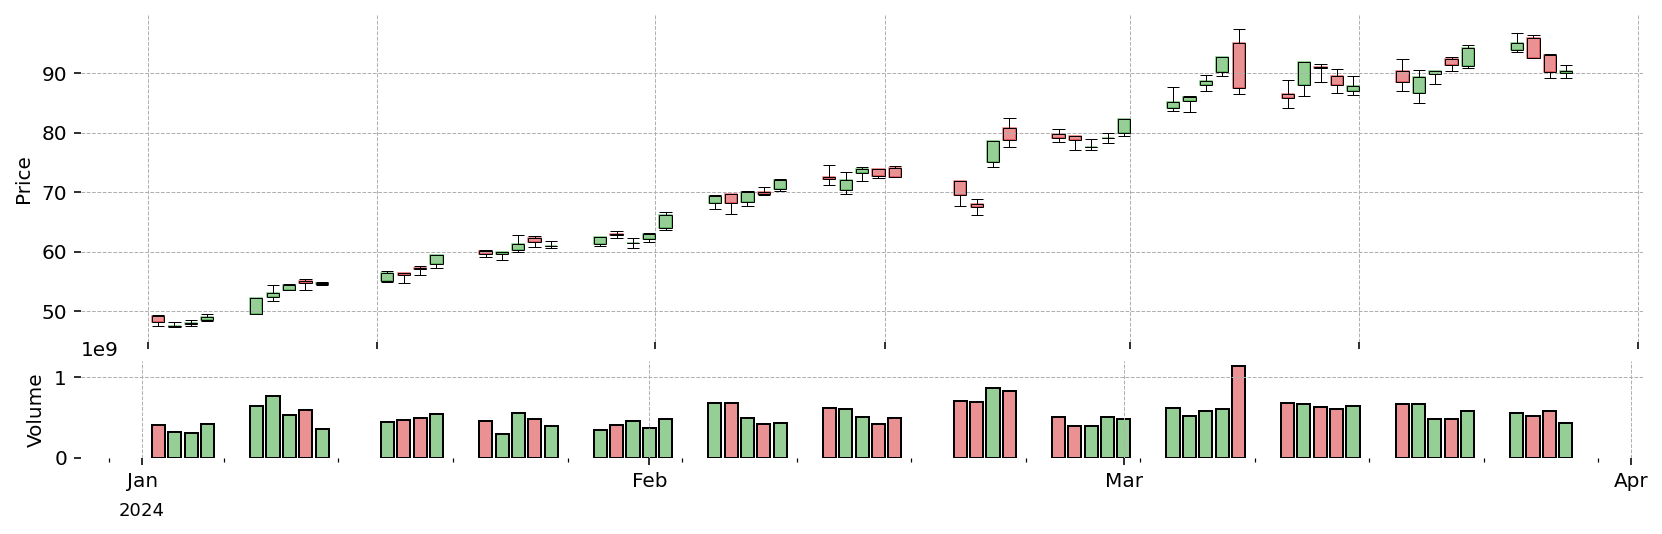

In [7]:
plot_candlesticks(df_train.loc["2024-01-01":"2024-03-31"]);

Anyway, forcasting. We will use the past to predict the future. One idea might be that the future will look just like today. This isn't so crazy, it's the so-called "random walk" assumption. The implied statistical model is:

$$
\begin{align}
P_t &= P_{t-1} + \varepsilon_t \\
\varepsilon_t &\sim N(0, \sigma)
\end{align}
$$

Prices today are the same as prices yesterday (in expectation). This seems pretty bad assumption, as there appears to be a trend. Nevertheless, stock prices (actually log prices, but I elide this detail here) are believed to follow a gaussian random walk. So it should forecast well enough!

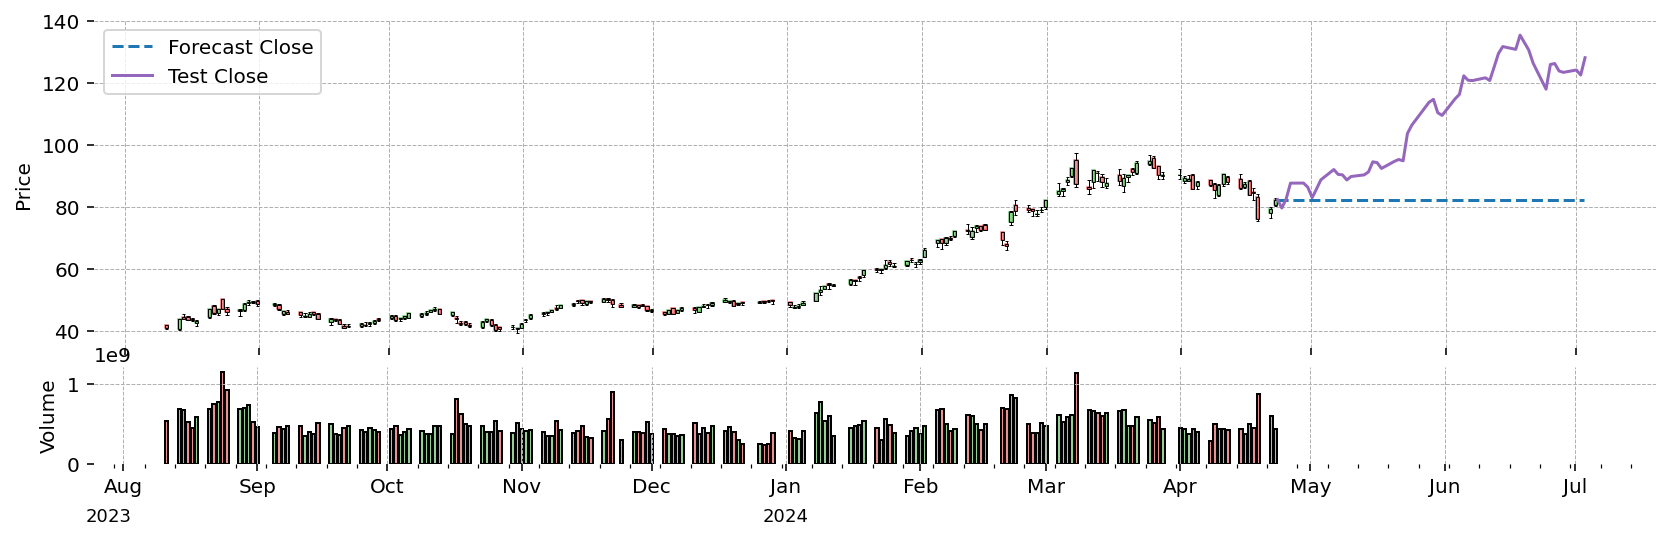

In [8]:
forecast_idx = pd.date_range(start=df_train.index[-1], end=df_test.index[-1], freq="B")
H = forecast_idx.shape[0]
rw_forecast = pd.DataFrame(np.full(H, df_train.Close.values[-1]), index=forecast_idx)
fig = plot_candlesticks(df_train)
fig.axes[0].plot(rw_forecast.index, rw_forecast.values, ls="--", label="Forecast Close")
fig.axes[0].plot(df_test.index, df_test.Close.values, color="tab:purple", label="Test Close")
fig.axes[0].legend()

fig.axes[1].bar(rw_forecast.index, np.full(H, 0))
plt.show()

Pretty terrible. We grossly underestimate the future price. We might not really believe the random walk assumption -- what if we consider **all** the data? If we weight all the data equally, this would look like predicting the future as the average of the time series:

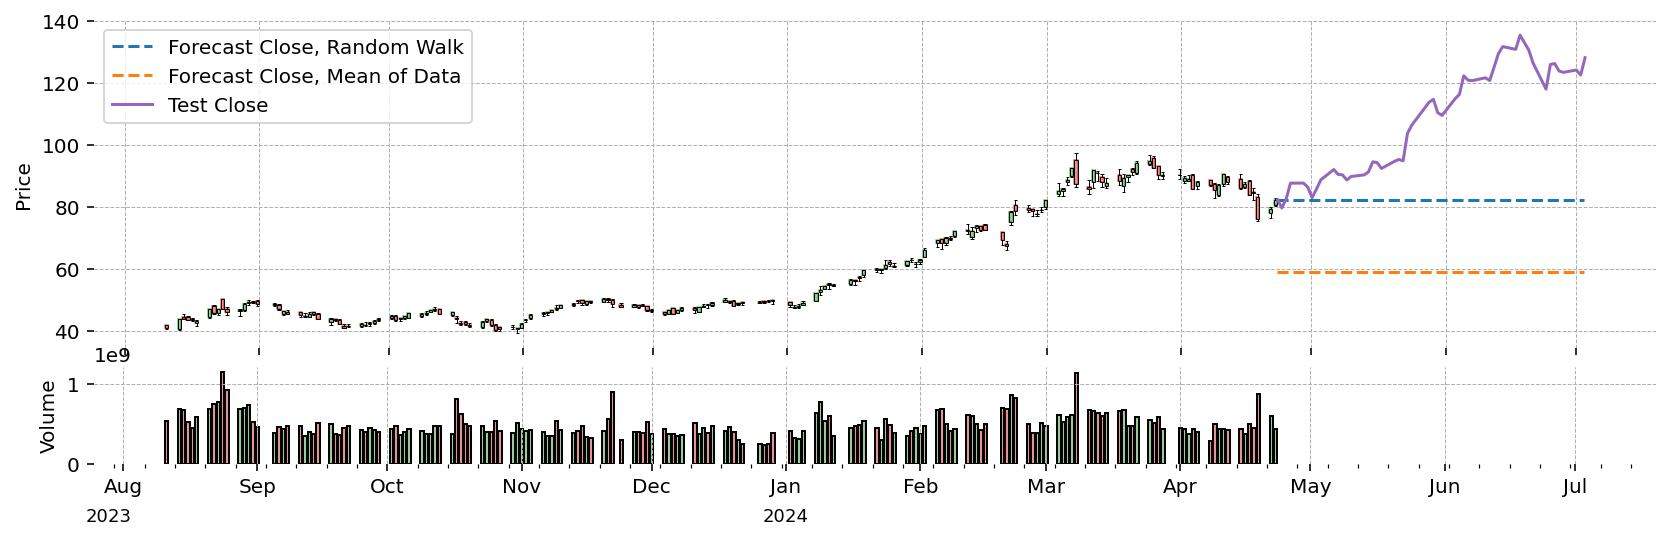

In [9]:
forecast_idx = pd.date_range(start=df_train.index[-1], end=df_test.index[-1], freq="B")
H = forecast_idx.shape[0]
rw_forecast = pd.DataFrame(np.full(H, df_train.Close.values[-1]), index=forecast_idx)
mean_forecast = pd.DataFrame(np.full(H, df_train.Close.mean()), index=forecast_idx)
fig = plot_candlesticks(df_train)
fig.axes[0].plot(
    rw_forecast.index, rw_forecast.values, ls="--", label="Forecast Close, Random Walk"
)
fig.axes[0].plot(
    rw_forecast.index, mean_forecast.values, ls="--", label="Forecast Close, Mean of Data"
)
fig.axes[0].plot(df_test.index, df_test.Close.values, color="tab:purple", label="Test Close")
fig.axes[0].legend()

fig.axes[1].bar(rw_forecast.index, np.full(H, 0))
plt.show()

Why is the average forecast even worse? Intuitively, we might not expect price values from 12 months ago to matter. Data from before the January-March 2024 increase is pulling the average down. Do we really believe that this entire run-up in valuation will be reversed tomorrow? Probably not.

We can view both of these forecasts as weighted functions of the data. Specifically, they are both $P_{t+h} = \sum_{t=0}^T w_t P_t$, where $w = \begin{bmatrix}0 & 0 & \cdots & 0 & 1\end{bmatrix}$ in the random walk case, and $w = \begin{bmatrix} \frac{1}{T} & \frac{1}{T} & \cdots & \frac{1}{T} & \frac{1}{T}\end{bmatrix}$ in the mean case.

What would be better is a weighting scheme that weights recent data more heavily than past data. This is the ETS model. We will choose:

$$
w = \begin{bmatrix} \alpha (1 - \alpha)^{T} & \alpha (1 - \alpha)^{T-1} \cdots & \alpha (1 - \alpha)^2 & \alpha (1 - \alpha) & \alpha \end{bmatrix}
$$

With $\alpha \in (0, 1)$ as a smoothing parameter that tells us how quickly the importance of past data decays as we move through time. 

This next plot shows how varying alpha changes the importance of past datapoints in the forecast. When alpha is very small (blue, hiding at the bottom), we're quite close to the mean situation where all datapoints are given equal weight. When alpha is large, only the recent past matters. At $\alpha=1$, we are in the random walk regime.

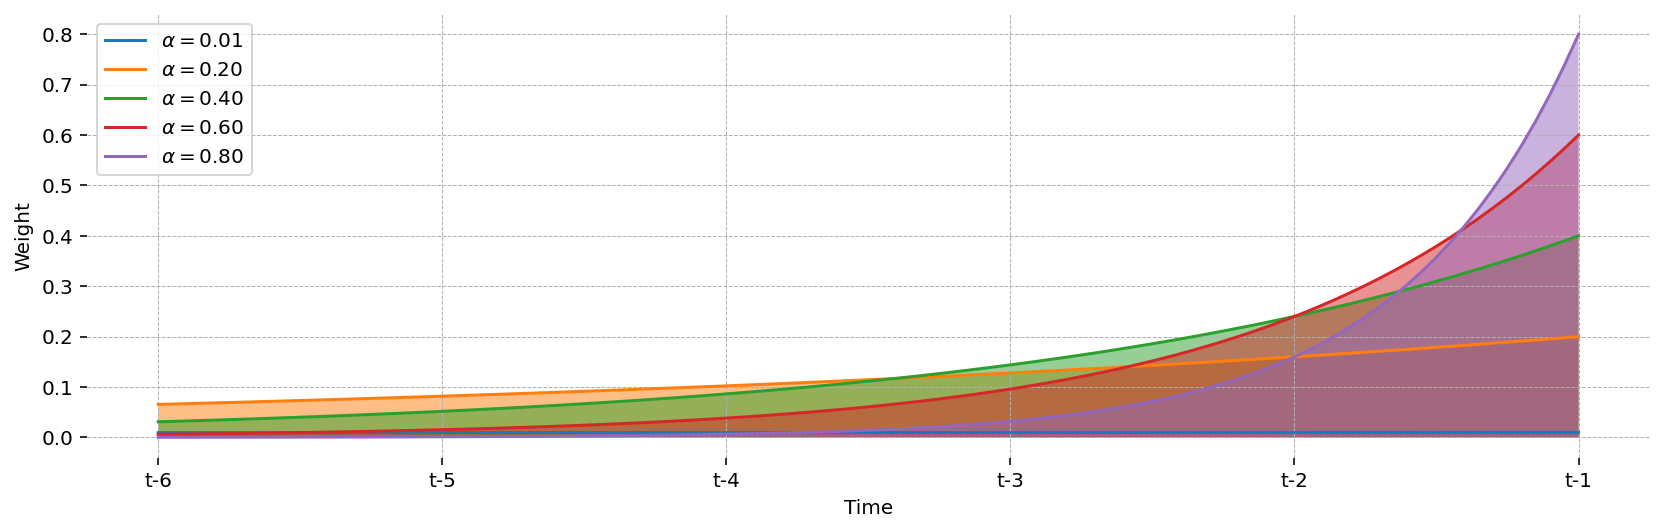

In [10]:
alphas = [0.01, 0.2, 0.4, 0.6, 0.8]
time_grid = np.linspace(0, 5, 100)

fig, ax = plt.subplots()
for i, alpha in enumerate(alphas):
    #     ax.bar(powers[::-1] + 0.15 * i, w_df.iloc[:, i], width=0.15)
    decay = alpha * (1 - alpha) ** time_grid[::-1]
    ax.fill_between(time_grid, 0, decay, alpha=0.5)
    ax.plot(time_grid, decay, label=f"$\\alpha = {alpha:0.2f}$")
ax.legend()
ax.set(
    ylabel="Weight",
    xlabel="Time",
    xticks=np.arange(6),
    xticklabels=[f"t-{h}" for h in range(6, 0, -1)],
)
plt.show()

For our purposes, it is important to note that the equation for the weights can be rewritten recursively. Assume we observe $P_0$, an initial price. The next forecasts will be:

# References

<a name="Brown1959"></a>
**Brown, Robert G.** *Statistical Forecasting for Inventory Control*. McGraw-Hill, 1959.

<a name="Holt1957"></a>
**Holt, Charles C.** "Forecasting Seasonals and Trends by Exponentially Weighted Averages." *ONR Memorandum No. 52*, Carnegie Institute of Technology, 1957. Reprinted in *International Journal of Forecasting*, 2004. https://doi.org/10.1016/j.ijforecast.2003.09.015

<a name="Winters1960"></a>
**Winters, Peter R.** "Forecasting Sales by Exponentially Weighted Moving Averages." *Management Science*, vol. 6, no. 3, 1960, pp. 324–42. https://doi.org/10.1287/mnsc.6.3.324